# Building a Dual Ibor Curve

The aim is to construct an IBOR curve that uses OIS discounting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.finutils import *
from financepy.products.funding import *

####################################################################
# FINANCEPY BETA Version 0.184 - This build:  19 Oct 2020 at 14:52 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



In [3]:
valuationDate = FinDate(18, 9, 2019)

## Building the Discount Curve

This is based on OIS rates. We anchor the short end using the overnight rate.

In [103]:
onRate = 0.045
spotDays = 0
settlementDate = valuationDate.addWeekDays(spotDays)

depoDCCType = FinDayCountTypes.THIRTY_E_360_ISDA
depos = []
spotDays = 2
settlementDate = valuationDate.addWeekDays(spotDays)
depo = FinIborDeposit(settlementDate, "1D", onRate, depoDCCType); depos.append(depo)

We use swaps with a regular term

In [105]:
oiss = []
swapType = FinSwapTypes.PAYER
fixedDCCType = FinDayCountTypes.ACT_365F
fixedFreqType = FinFrequencyTypes.SEMI_ANNUAL

swap = FinOIS(settlementDate, "1Y", swapType, onRate + 0.0001, fixedFreqType, fixedDCCType); oiss.append(swap)
swap = FinOIS(settlementDate, "2Y", swapType, onRate + 0.0003, fixedFreqType, fixedDCCType); oiss.append(swap)
swap = FinOIS(settlementDate, "3Y", swapType, onRate + 0.0010, fixedFreqType, fixedDCCType); oiss.append(swap)
swap = FinOIS(settlementDate, "4Y", swapType, onRate + 0.0015, fixedFreqType, fixedDCCType); oiss.append(swap)
swap = FinOIS(settlementDate, "5Y", swapType, onRate + 0.0020, fixedFreqType, fixedDCCType); oiss.append(swap)
swap = FinOIS(settlementDate, "7Y", swapType, onRate + 0.0030, fixedFreqType, fixedDCCType); oiss.append(swap)
swap = FinOIS(settlementDate, "10Y", swapType, onRate + 0.0035, fixedFreqType, fixedDCCType); oiss.append(swap)

In [106]:
oisCurve = FinOISCurve(settlementDate, depos, [], oiss, FinInterpTypes.FLAT_FORWARDS)

Let's just check a repricing by looking at the value of the longest OIS.

In [107]:
for swap in oiss:
    v_single = swap.value(valuationDate, oisCurve) / swap._notional
    print(swap._maturityDate, v_single)

MON 21 SEP 2020 -6.951032046345062e-10
MON 20 SEP 2021 -6.724293052684516e-10
TUE 20 SEP 2022 -7.583215628983453e-10
WED 20 SEP 2023 -7.610002357978374e-10
FRI 20 SEP 2024 -8.076569065451622e-10
MON 21 SEP 2026 -2.4330802261829378e-14
THU 20 SEP 2029 -8.981442078948021e-13


This is effectively zero. So they are all repriced.

## Building the 3M IBOR Curve

We use ON rate, 3M Ibor FRAs and IBOR swaps with a 3M floating Leg (this is the default for FinIborSwap)

In [225]:
depoDCCType = FinDayCountTypes.THIRTY_E_360_ISDA
depos = []
depo = FinIborDeposit(settlementDate, "1D", onRate, depoDCCType); depos.append(depo)

payFixed = True
fras = []

# 1 x 4 FRA
fraRate = onRate + 0.0003
fraSettlementDate = settlementDate.addMonths(1)
fraMaturityDate = settlementDate.addMonths(4)
fra = FinIborFRA(fraSettlementDate, fraMaturityDate, fraRate, depoDCCType)
fras.append(fra)

# 2 x 5 FRA
fraRate = onRate + 0.0005
fraSettlementDate = settlementDate.addMonths(2)
fraMaturityDate = settlementDate.addMonths(5)
fra = FinIborFRA(fraSettlementDate, fraMaturityDate, fraRate, depoDCCType)
fras.append(fra)

# 3 x 6 FRA
fraRate = onRate + 0.0007
fraSettlementDate = settlementDate.addMonths(3)
fraMaturityDate = settlementDate.addMonths(6)
fra = FinIborFRA(fraSettlementDate, fraMaturityDate, fraRate, depoDCCType)
fras.append(fra)

# 4 x 7 FRA
fraRate = onRate + 0.0007
fraSettlementDate = settlementDate.addMonths(4)
fraMaturityDate = settlementDate.addMonths(7)
fra = FinIborFRA(fraSettlementDate, fraMaturityDate, fraRate, depoDCCType)
fras.append(fra)

# 5 x 8 FRA
fraRate = onRate + 0.0008
fraSettlementDate = settlementDate.addMonths(5)
fraMaturityDate = settlementDate.addMonths(8)
fra = FinIborFRA(fraSettlementDate, fraMaturityDate, fraRate, depoDCCType)
fras.append(fra)

swaps = []
swapType = FinSwapTypes.PAYER
fixedDCCType = FinDayCountTypes.ACT_365F
fixedFreqType = FinFrequencyTypes.SEMI_ANNUAL

swap = FinIborSwap(settlementDate, "1Y", swapType, 0.0470, fixedFreqType, fixedDCCType); swaps.append(swap)
swap = FinIborSwap(settlementDate, "3Y", swapType, 0.0475, fixedFreqType, fixedDCCType); swaps.append(swap)
swap = FinIborSwap(settlementDate, "5Y", swapType, 0.0490, fixedFreqType, fixedDCCType); swaps.append(swap)
swap = FinIborSwap(settlementDate, "7Y", swapType, 0.0510, fixedFreqType, fixedDCCType); swaps.append(swap)
swap = FinIborSwap(settlementDate, "10Y", swapType, 0.0520, fixedFreqType, fixedDCCType); swaps.append(swap)

Let's first build a single curve that assumes index and funding rates are same

Note that for ease of comparison I use flat forward interpolation

In [226]:
iborSingleCurve = FinIborSingleCurve(settlementDate, depos, fras, swaps, FinInterpTypes.FLAT_FORWARDS)

Let's check repricing of FRAs and Swaps

In [227]:
for fra in fras:
    v = fra.value(valuationDate, iborSingleCurve)/ fra._notional
    print(fra._maturityDate, v)

MON 20 JAN 2020 8.569726199008502e-14
THU 20 FEB 2020 3.570706235902959e-15
FRI 20 MAR 2020 1.5006369344473434e-15
MON 20 APR 2020 -8.834583537919759e-16
WED 20 MAY 2020 -1.7668249297206217e-16


In [228]:
for swap in swaps:
    v = swap.value(valuationDate, iborSingleCurve)/ swap._notional
    print(swap._maturityDate, v)

MON 21 SEP 2020 4.009052645415067e-15
TUE 20 SEP 2022 -1.9936123862862586e-14
FRI 20 SEP 2024 -3.0355295166373255e-14
MON 21 SEP 2026 -5.349284037947655e-14
THU 20 SEP 2029 -1.865497324615717e-12


The fit looks perfect

## Building the Dual Curve

Let's build a dual curve that incorporates funding and index curve differential.

In [229]:
iborDualCurve = FinIborDualCurve(settlementDate, oisCurve, depos, fras, swaps, FinInterpTypes.FLAT_FORWARDS)

In [230]:
for fra in fras:
    v_dual = fra.value(valuationDate, oisCurve, iborDualCurve) / fra._notional
    print(fra._maturityDate, v_dual)

MON 20 JAN 2020 -9.038526993379982e-16
THU 20 FEB 2020 9.80521724237145e-13
FRI 20 MAR 2020 8.351811257144023e-13
MON 20 APR 2020 9.146440178967443e-13
WED 20 MAY 2020 1.0014305096571636e-12


In [231]:
for swap in swaps:
    v_dual = swap.value(valuationDate, oisCurve, iborDualCurve) / swap._notional
    print(swap._maturityDate, v_dual)

MON 21 SEP 2020 1.5425030142068863e-15
TUE 20 SEP 2022 -1.4551915228366853e-16
FRI 20 SEP 2024 1.4551915228366853e-16
MON 21 SEP 2026 -5.238689482212067e-16
THU 20 SEP 2029 -5.256151780486107e-14


This is within the allowed tolerance.

## Comparison of Curves

We examine the forward rates of the three curves

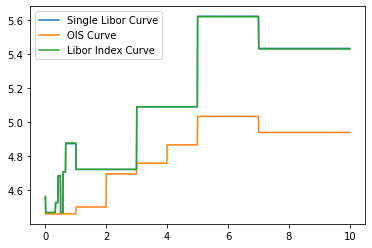

In [232]:
years = np.linspace(0, 10, 1201)
dates = settlementDate.addYears(years)
    
singleCurveFwds = iborSingleCurve.fwd(dates)   
plt.plot(years, singleCurveFwds*100, label="Single Libor Curve")
 
oisCurveFwds = oisCurve.fwd(dates)    
plt.plot(years, oisCurveFwds*100.0, label="OIS Curve")

indexCurveFwds = iborDualCurve.fwd(dates)    
plt.plot(years, indexCurveFwds*100.0, label="Libor Index Curve")
        
plt.legend();

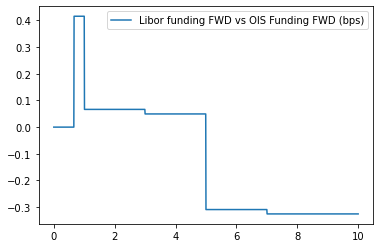

In [233]:
diff = (indexCurveFwds - singleCurveFwds)*10000
plt.plot(years, diff, label="Libor funding FWD vs OIS Funding FWD (bps)")
plt.legend()

The difference is small but not negligible.

Copyright (c) Dominic O'Kane 2020